In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchsummary
import torchvision.transforms as transforms
torch.manual_seed(10)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE =128

# Define transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 27981830.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [13]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
       # self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
       # out = self.layer4(out)
       # out = F.avg_pool2d(out, 4)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [14]:
model = ResNet(BasicBlock, [3,3,3]).to(device)

In [15]:
torchsummary.summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [16]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [17]:
EPOCHS = 100
learning_rate = 0.01
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learning_rate/10.0)

In [19]:
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

def train(model, train_loader, optimizer, criterion, device):
  train_loss = 0
  train_acc = 0
  model.train()
  for (x, y) in train_loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    acc = calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    train_loss += loss.item()
    train_acc += acc.item()

  return train_loss / len(train_loader), train_acc / len(train_loader)

def evaluate(model, test_loader, criterion, device):
  test_loss = 0
  test_acc = 0
  model.eval()

  with torch.no_grad():
    for (x,y) in test_loader:
      x, y = x.to(device), y.to(device)
      y_pred = model(x)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)

      test_loss += loss.item()
      test_acc += acc.item()

  return test_loss / len(test_loader), test_acc / len(test_loader)

best_test_acc = float('-inf')

for epoch in range(EPOCHS):
  train_loss, train_acc = train(model,train_loader,optimizer,criterion,device)
  test_loss, test_acc = evaluate(model,test_loader,criterion,device)
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)
  if test_acc > best_test_acc:
    torch.save(model,"best_model_sgd_modular_reducedlayers.pt")
    best_test_acc = test_acc
  print('Epoch: %d, Train Loss=%.2f,Train Accuracy=%.2f, Test Loss=%.2f,Test Accuracy=%.2f'%(epoch+1,train_loss,train_acc,test_loss,test_acc))

Epoch: 1, Train Loss=1.19,Train Accuracy=0.57, Test Loss=1.33,Test Accuracy=0.58
Epoch: 2, Train Loss=0.90,Train Accuracy=0.68, Test Loss=0.88,Test Accuracy=0.70
Epoch: 3, Train Loss=0.72,Train Accuracy=0.75, Test Loss=0.73,Test Accuracy=0.75
Epoch: 4, Train Loss=0.62,Train Accuracy=0.78, Test Loss=0.56,Test Accuracy=0.81
Epoch: 5, Train Loss=0.56,Train Accuracy=0.81, Test Loss=0.51,Test Accuracy=0.83
Epoch: 6, Train Loss=0.50,Train Accuracy=0.83, Test Loss=0.46,Test Accuracy=0.85
Epoch: 7, Train Loss=0.46,Train Accuracy=0.84, Test Loss=0.43,Test Accuracy=0.85
Epoch: 8, Train Loss=0.42,Train Accuracy=0.86, Test Loss=0.40,Test Accuracy=0.87
Epoch: 9, Train Loss=0.39,Train Accuracy=0.86, Test Loss=0.41,Test Accuracy=0.86
Epoch: 10, Train Loss=0.36,Train Accuracy=0.88, Test Loss=0.39,Test Accuracy=0.87
Epoch: 11, Train Loss=0.34,Train Accuracy=0.88, Test Loss=0.39,Test Accuracy=0.87
Epoch: 12, Train Loss=0.32,Train Accuracy=0.89, Test Loss=0.45,Test Accuracy=0.85
Epoch: 13, Train Loss=0.3

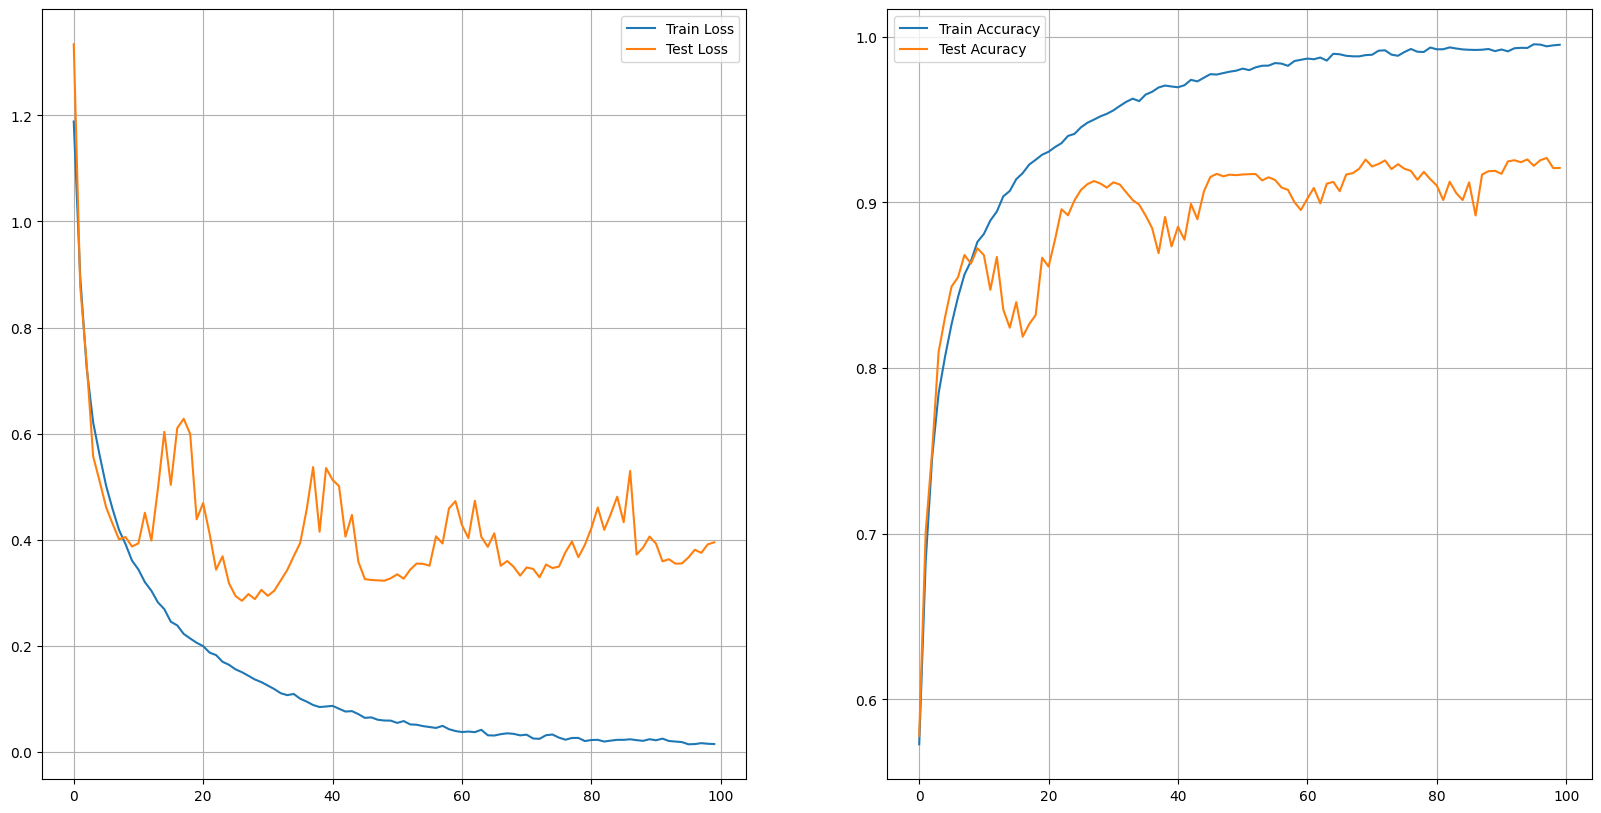

In [20]:
import matplotlib.pyplot as plt

f, (fig1, fig2) = plt.subplots(1, 2, figsize=(20, 10))
fig1.plot(range(len(train_loss_list)), train_loss_list, label='Train Loss')
fig1.plot(range(len(train_loss_list)), test_loss_list, label='Test Loss')
fig2.plot(range(len(train_loss_list)), train_acc_list, label='Train Accuracy')
fig2.plot(range(len(train_loss_list)), test_acc_list, label='Test Acuracy')
fig1.grid(True)
fig2.grid(True)
fig1.legend()
fig2.legend()
f.savefig("./trainTestCurveSGD_Modular_reducedlayers.png")

In [21]:
model = torch.load('best_model_sgd_modular_reducedlayers.pt')
best_test_loss, best_test_acc = evaluate(model,test_loader,criterion,device)
print('Test Loss=%.2f,Test Accuracy=%.2f'%(best_test_loss,best_test_acc))

Test Loss=0.38,Test Accuracy=0.93
